In [325]:
using OrdinaryDiffEq
using ModelingToolkit
using DataDrivenDiffEq
using LinearAlgebra, DiffEqSensitivity, Optim
using DiffEqFlux, Flux
using Plots
gr()

Plots.GRBackend()

## Generate the (noisy) training dataset from:


## $$
\begin{aligned}
  \dot{x} = \alpha x - \beta xy \\
  \dot{y} =  \gamma xy - \delta y 
\end{aligned}
$$


In [326]:
function LV(du, u, p, t)
    α, β, γ, δ = p
    du[1] = α*u[1] - β*u[2]*u[1]
    du[2] = γ*u[1]*u[2]  - δ*u[2]
end


p_ = Float32[1.3, 0.9, 0.8, 1.8]


# Define the experimental parameter

tspan = (0.0f0,3.0f0)
u0 = Float32[0.44249296,4.6280594]
p_ = Float32[1.3, 0.9, 0.8, 1.8]

prob = ODEProblem(LV, u0, tspan, p_)

solution = solve(prob, Vern7(), abstol=1e-12, reltol=1e-12, saveat = 0.1)


X = Array(solution)

# Add noise to the data
println("Generate noisy data")
Xₙ = X + Float32(1e-3)*randn(eltype(X), size(X));

Generate noisy data


## Plot the training dataset

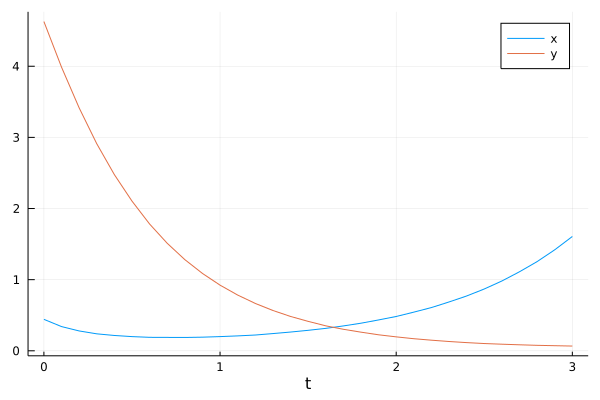

In [327]:
#plot(solution)
#plot(Array(solution)[1, :], Array(solution)[2, :])
#plot(Xₙ[1, :], Xₙ[2, :])
plot(solution.t, Xₙ[1, :], xlabel = "t", label = "x")
plot!(solution.t, Xₙ[2, :], label = "y")

## UADE

In [328]:
# Neural network

L = FastChain(FastDense(2, 32, tanh), FastDense(32, 32, tanh), FastDense(32, 2))
p = initial_params(L)


# ODE

function dudt_(u, p, t)
    x, y = u
    z = L(u,p)
    [p_[1]*x + z[1],
    -p_[4]*y + z[2]]
end

# ODE problem
prob_nn = ODEProblem(dudt_, u0, tspan, p)
sol_nn = solve(prob_nn, Tsit5(), u0 = u0, p = p, saveat = 0.1);

## Plot the untrained solution

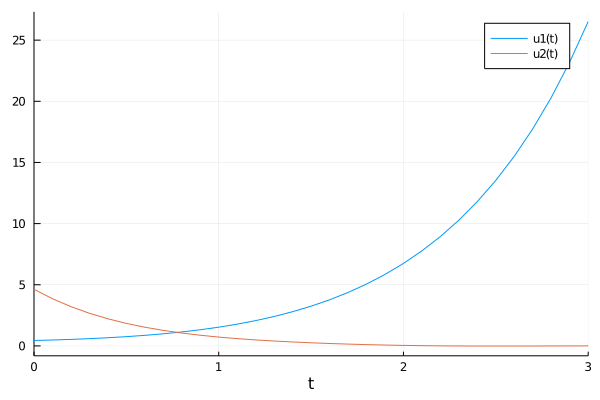

In [329]:
plot(sol_nn, xlabel = "t")
#plot(Array(sol_nn)[1, :], Array(sol_nn)[2, :])

## Loss function

In [330]:
# This function is used in the loss
function predict(θ)
    Array(solve(prob_nn, Vern7(), u0 = u0, p=θ, saveat = 0.1,
                         abstol=1e-6, reltol=1e-6,
                         sensealg = InterpolatingAdjoint(autojacvec=ReverseDiffVJP())))
end


# No regularisation right now
function loss(θ)
    pred = predict(θ)
    sum(abs2, Xₙ .- pred)
end


# Test
#loss(p)


const losses = []

# The callback function is cb(p,args...) where the arguments are the extra returns from the loss
callback(θ, l) = begin
    push!(losses, l)
    if length(losses)%10==0
        println("Current loss after $(length(losses)) iterations: $(losses[end])")    
    end
    
    # The callback function must return a boolean where if true, then the optimizer will prematurely end the optimization
    false
end

callback (generic function with 1 method)

## Training with ADAM

In [331]:
# Train with ADAM
res1 = DiffEqFlux.sciml_train(loss, p, ADAM(0.01), cb=callback, maxiters = 300)

Current loss after 10 iterations: 13.102196


Current loss after 20 iterations: 11.965828


loss: 12.1:  10%|████                                   |  ETA: 0:03:16

Current loss after 30 iterations: 12.050089


loss: 11.6:  13%|██████                                 |  ETA: 0:03:01

Current loss after 40 iterations: 11.56102


loss: 10.8:  17%|███████                                |  ETA: 0:02:48

Current loss after 50 iterations: 10.845159


loss: 10.1:  20%|████████                               |  ETA: 0:02:37

Current loss after 60 iterations: 10.093279


Current loss after 70 iterations: 9.383382


loss: 8.74:  27%|███████████                            |  ETA: 0:02:21

Current loss after 80 iterations: 8.735202


loss: 8.14:  30%|████████████                           |  ETA: 0:02:13

Current loss after 90 iterations: 8.144238


loss: 7.6:  33%|██████████████                          |  ETA: 0:02:07

Current loss after 100 iterations: 7.601194


loss: 7.1:  37%|███████████████                         |  ETA: 0:01:59

Current loss after 110 iterations: 7.0984874


loss: 6.63:  40%|████████████████                       |  ETA: 0:01:50

Current loss after 120 iterations: 6.6303697


loss: 6.19:  43%|█████████████████                      |  ETA: 0:01:44

Current loss after 130 iterations: 6.191452


loss: 5.78:  47%|███████████████████                    |  ETA: 0:01:38

Current loss after 140 iterations: 5.7764297


loss: 5.38:  50%|████████████████████                   |  ETA: 0:01:31

Current loss after 150 iterations: 5.3805695


loss: 5:  53%|███████████████████████                   |  ETA: 0:01:25

Current loss after 160 iterations: 5.000565


loss: 4.63:  57%|███████████████████████                |  ETA: 0:01:19

Current loss after 170 iterations: 4.6341767


loss: 4.28:  60%|████████████████████████               |  ETA: 0:01:13

Current loss after 180 iterations: 4.2788935


loss: 3.93:  63%|█████████████████████████              |  ETA: 0:01:06

Current loss after 190 iterations: 3.9314594


loss: 3.59:  67%|██████████████████████████             |  ETA: 0:01:01

Current loss after 200 iterations: 3.5889747


loss: 3.25:  70%|████████████████████████████           |  ETA: 0:00:53

Current loss after 210 iterations: 3.2500393


loss: 2.92:  73%|█████████████████████████████          |  ETA: 0:00:47

Current loss after 220 iterations: 2.9152224


loss: 2.59:  77%|██████████████████████████████         |  ETA: 0:00:41

Current loss after 230 iterations: 2.586626


loss: 2.27:  80%|████████████████████████████████       |  ETA: 0:00:35

Current loss after 240 iterations: 2.2677195


loss: 1.96:  83%|█████████████████████████████████      |  ETA: 0:00:29

Current loss after 250 iterations: 1.9631082


loss: 1.68:  87%|██████████████████████████████████     |  ETA: 0:00:23

Current loss after 260 iterations: 1.6784301


loss: 1.42:  90%|████████████████████████████████████   |  ETA: 0:00:18

Current loss after 270 iterations: 1.4199072


loss: 1.19:  93%|█████████████████████████████████████  |  ETA: 0:00:12

Current loss after 280 iterations: 1.1935637


loss: 1:  97%|█████████████████████████████████████████ |  ETA: 0:00:06

Current loss after 290 iterations: 1.0037761


loss: 0.852: 100%|██████████████████████████████████████| Time: 0:02:54


Current loss after 300 iterations: 0.85200363


 * Status: success

 * Candidate solution
    Final objective value:     8.520036e-01

 * Found with
    Algorithm:     ADAM

 * Convergence measures
    |x - x'|               = NaN ≰ 0.0e+00
    |x - x'|/|x'|          = NaN ≰ 0.0e+00
    |f(x) - f(x')|         = NaN ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = NaN ≰ 0.0e+00
    |g(x)|                 = NaN ≰ 0.0e+00

 * Work counters
    Seconds run:   190  (vs limit Inf)
    Iterations:    300
    f(x) calls:    300
    ∇f(x) calls:   300


## Training with BFGS

In [332]:
res2 = DiffEqFlux.sciml_train(loss, res1.minimizer, BFGS(initial_stepnorm=0.01), cb=callback, maxiters = 1000)

Current loss after 310 iterations: 0.12972073
Current loss after 320 iterations: 0.06477452
Current loss after 330 iterations: 0.03295546
Current loss after 340 iterations: 0.019628067
Current loss after 350 iterations: 0.011706856
Current loss after 360 iterations: 0.0043204753
Current loss after 370 iterations: 0.0036185486
Current loss after 380 iterations: 0.0032971005
Current loss after 390 iterations: 0.003012015
Current loss after 400 iterations: 0.002402229
Current loss after 410 iterations: 0.0023299193
Current loss after 420 iterations: 0.0021499752
Current loss after 430 iterations: 0.001354831
Current loss after 440 iterations: 0.0009034281
Current loss after 450 iterations: 0.00070109876
Current loss after 460 iterations: 0.00064933853
Current loss after 470 iterations: 0.00059343275


 * Status: success

 * Candidate solution
    Final objective value:     5.934327e-04

 * Found with
    Algorithm:     BFGS

 * Convergence measures
    |x - x'|               = 0.00e+00 ≤ 0.0e+00
    |x - x'|/|x'|          = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 2.14e-02 ≰ 1.0e-08

 * Work counters
    Seconds run:   118  (vs limit Inf)
    Iterations:    169
    f(x) calls:    540
    ∇f(x) calls:   540


## Plot the loss

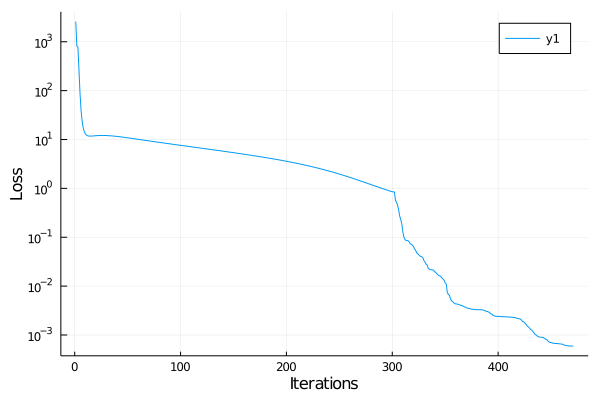

In [333]:
plot(losses, yaxis=:log, xlabel = "Iterations", ylabel = "Loss")

## Plot the approximation and the original data

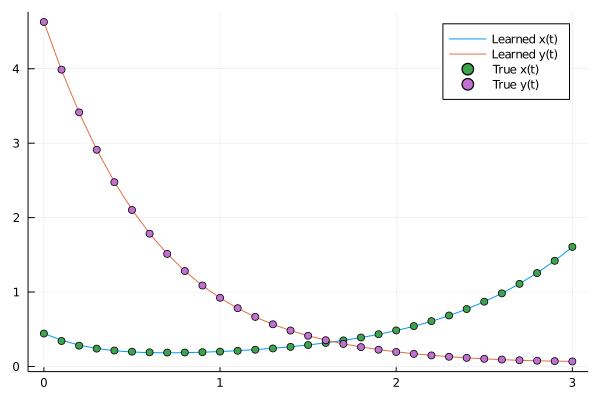

In [334]:
NNsolution = predict(res2.minimizer)
# Trained on noisy data vs real solution
plot(solution.t, NNsolution', label = ["Learned x(t)" "Learned y(t)"])
scatter!(solution.t, X', label = ["True x(t)" "True y(t)"])

## Prediction

In [335]:
function dudt2_(u, p, t)
    x, y = u
    z = L(u,p)
    [p_[1]*x + z[1],
    -p_[4]*y + z[2]]
end

# ODE problem
tspan2 = (0.0f0, 5.0f0)
prob_nn2 = ODEProblem(dudt2_, u0, tspan2, res2.minimizer)
sol_nn2 = solve(prob_nn2, Tsit5(), u0 = u0, saveat = 0.1);

## Test the prediction

In [336]:
tspan_test = (0.0f0, 5.0f0)
prob_test = ODEProblem(LV, u0, tspan_test, p_)
solution_test = solve(prob_test, Vern7(), saveat = 0.05);

## Plot Toghether True And Prediction
### Phase Space Plot

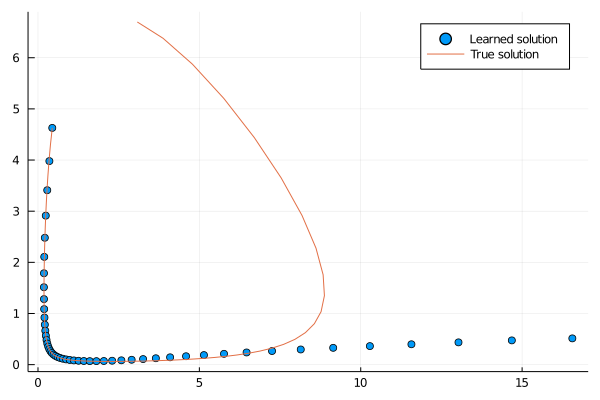

In [337]:
#scatter(Array(solution_test)[1, :], Array(solution_test)[2, :])
scatter(Array(sol_nn2)[1, :], Array(sol_nn2)[2, :], label = "Learned solution")
plot!(Array(solution_test)[1, :], Array(solution_test)[2, :], label = "True solution")

## Plot $x(t)$ and $y(t)$

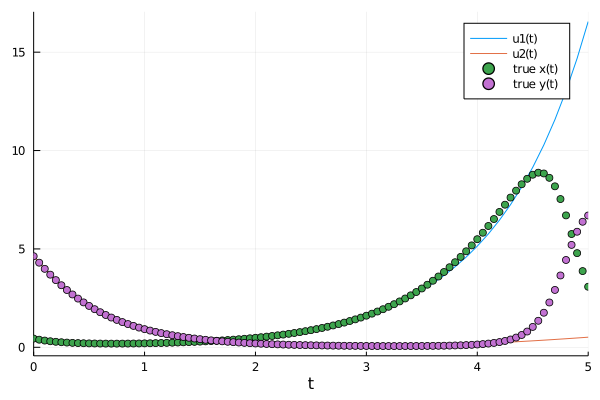

In [338]:
plot(sol_nn2)
scatter!(solution_test.t, Array(solution_test)[1, :], label = "true x(t)")
scatter!(solution_test.t, Array(solution_test)[2, :], label = "true y(t)")

# SINDy Sparse Identification of Non-linear Dynamics
### Ideal derivatives

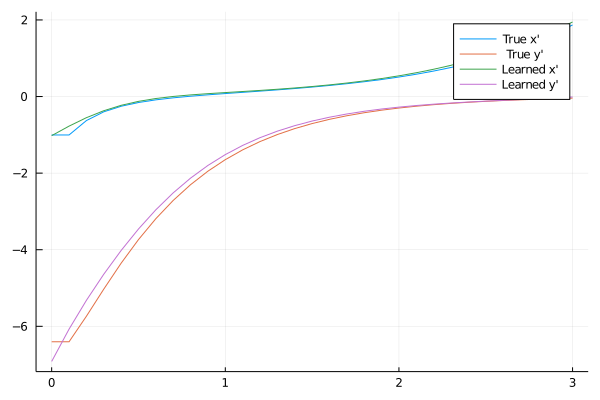

In [339]:
DX = Array(solution(solution.t, Val{1}))

prob_nn2 = ODEProblem(dudt_, u0, tspan, res2.minimizer)
_sol = solve(prob_nn2, Tsit5())
DX_ = Array(_sol(solution.t, Val{1}))

plot(solution.t, DX', label = ["True x'" " True y'"])
plot!(solution.t, DX_', label = ["Learned x'" "Learned y'"])

## The learned derivatives

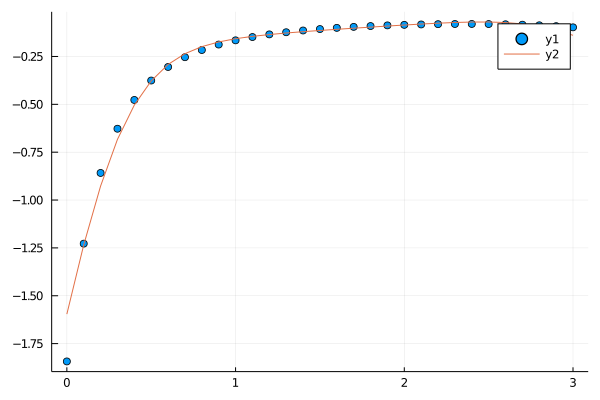

In [340]:
# Ideal data
L̄ = [-p_[2]*(X[1,:].*X[2,:])';p_[3]*(X[1,:].*X[2,:])']
# Neural network guess
L̂ = L(Xₙ, res2.minimizer)

scatter(solution.t, L̄'[:, 1])
plot!(solution.t, L̂'[:, 1])

# Plot the error
#scatter(abs.(L̄-L̂)', yaxis = :log)

## Create a basis for the sparse identification

In [341]:
@variables u[1:2]

# Lots of polynomials
polys = Operation[1]

for i ∈ 1:5
    push!(polys, u[1]^i)
    push!(polys, u[2]^i)
    for j ∈ i:5
        if i != j
            push!(polys, (u[1]^i)*(u[2]^j))
            push!(polys, u[2]^i*u[1]^i)
        end
    end
end

# And some other stuff
h = [cos.(u)...; sin.(u)...; polys...]
basis = Basis(h, u)

29 dimensional basis in ["u₁", "u₂"]

## Optimizer for the SINDy problem

In [380]:
opt = SR3()

# Create the thresholds which should be used in the search process
λ = exp10.(-7:0.1:3)

# Target function to choose the results from; x = L0 of coefficients and L2-Error of the model
g(x) = x[1] < 1 ? Inf : norm(x, 2)

g (generic function with 1 method)

## Test on original data and without further knowledge (fail)

In [345]:
println("SINDy on full ideal, unavailable data")
Ψ = SINDy(Xₙ[:, :], DX[:, :], basis, λ, opt, g = g, maxiter = 10000) # Fail
println(Ψ)
print_equations(Ψ)

SINDy on full ideal, unavailable data
Sparse Identification Result
No. of Parameters : 4
Active terms : 4
   Equation 1 : 3
   Equation 2 : 1
Overall error (L2-Norm) : 3.3759487
   Equation 1 : 1.9532388
   Equation 2 : 1.4227098
AICC :
   Equation 1 : 4.8605056
   Equation 2 : 1.0183176

SR3{Float64,UnionAll}(0.3154786722400966, 1.0, ProximalOperators.NormL1) converged after 2704 iterations.

2 dimensional basis in ["u₁", "u₂"]
du₁ = sin(u₁) * p₂ + cos(u₂) * p₁ + u₁ ^ 2 * p₃
du₂ = p₄ * u₂



## Test on UADE derivative data

In [381]:
println("SINDy on learned, partial, available data")
Ψ = SINDy(Xₙ[:, 2:end], L̂[:, 2:end], basis, λ,  opt, g = g, maxiter = 10000, normalize = true, denoise = true) # Succeed
println(Ψ)
print_equations(Ψ)

SINDy on learned, partial, available data
Sparse Identification Result
No. of Parameters : 190
Active terms : 190
   Equation 1 : 95
   Equation 2 : 95
Overall error (L2-Norm) : NaN
   Equation 1 : NaN
   Equation 2 : NaN
AICC :
   Equation 1 : NaN
   Equation 2 : NaN

SR3{Float64,UnionAll}(4.999999999999999e-15, 1.0, ProximalOperators.NormL1) did not converge after 10000 iterations.

2 dimensional basis in ["x", "y", "z"]
f_1 = x ^ 2 * p₉ + x ^ 3 * p₂₅ + x ^ 4 * p₅₃ + y ^ 2 * p₁₀ + y ^ 3 * p₂₆ + y ^ 4 * p₅₄ + z ^ 2 * p₁₁ + z ^ 3 * p₂₇ + z ^ 4 * p₅₅ + p₂ * x + p₃ * y + p₄ * z + x ^ 2 * y ^ 2 * p₁₈ + x ^ 2 * z ^ 2 * p₂₀ + x ^ 2 * z ^ 3 * p₃₆ + x ^ 2 * z ^ 4 * p₆₄ + x ^ 2 * p₁₂ * y + x ^ 3 * y ^ 2 * p₃₄ + x ^ 3 * y ^ 3 * p₄₃ + x ^ 3 * z ^ 3 * p₄₅ + x ^ 3 * z ^ 4 * p₇₃ + x ^ 3 * p₂₈ * y + x ^ 4 * y ^ 2 * p₆₂ + x ^ 4 * y ^ 3 * p₇₁ + x ^ 4 * y ^ 4 * p₈₃ + x ^ 4 * z ^ 4 * p₈₅ + x ^ 4 * p₅₆ * y + y ^ 2 * z ^ 2 * p₁₉ + y ^ 2 * p₁₃ * z + y ^ 3 * z ^ 2 * p₃₅ + y ^ 3 * z ^ 3 * p₄₄ + y ^ 3 * p₂₉ *

## Extract the parameter

In [353]:
p̂ = parameters(Ψ)
println("First parameter guess : $(p̂)")

First parameter guess : Float32[-0.73177266, 0.65157366]


## Define the ODE with the new identified unknown term

In [348]:
unknown_sys = ODESystem(Ψ)
unknown_eq = ODEFunction(unknown_sys);

In [349]:
function dudt(du, u, p, t)
    # Add SINDy Term
    α, δ, β, γ = p
    z = unknown_eq(u, [β; γ], t)
    du[1] = α*u[1] + z[1]
    du[2] = -δ*u[2] + z[2]
end

dudt (generic function with 1 method)

## Create the approximated problem and solution

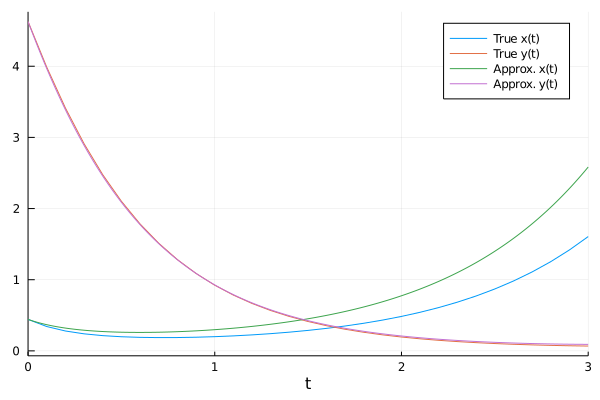

In [350]:
ps = [p_[[1,4]]; p̂]
approximate_prob = ODEProblem(dudt, u0, tspan, ps)
approximate_solution = solve(approximate_prob, Tsit5(), saveat = 0.01)

# Plot
plot(solution, label = ["True x(t)" "True y(t)"])
plot!(approximate_solution, label = ["Approx. x(t)" "Approx. y(t)"])

## Look at long term prediction

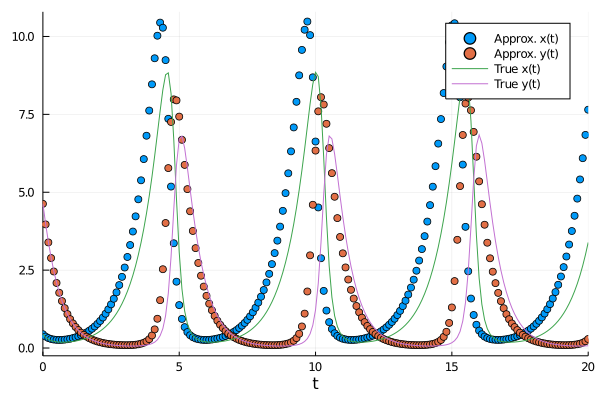

In [351]:
t_long = (0.0, 20.0)
approximate_prob = ODEProblem(dudt, u0, t_long, ps)
approximate_solution_long = solve(approximate_prob, Tsit5(), saveat = 0.1) # Using higher tolerances here results in exit of julia
scatter(approximate_solution_long, label = ["Approx. x(t)" "Approx. y(t)"])

true_prob = ODEProblem(LV, u0, t_long, p_)
true_solution_long = solve(true_prob, Tsit5(), saveat = approximate_solution_long.t)
plot!(true_solution_long, label = ["True x(t)" "True y(t)"])

--------------------------------------------
--------------------------------------------
--------------------------------------------

## How Sparse Identification work, simple example
########################################################

In [367]:
using DataDrivenDiffEq
using ModelingToolkit
using OrdinaryDiffEq

using LinearAlgebra
using Plots
gr()

# Create a test problem
function lorenz(u,p,t)
    x, y, z = u
    ẋ = 10.0*(y - x)
    ẏ = x*(28.0-z) - y
    ż = x*y - (8/3)*z
    return [ẋ, ẏ, ż]
end

u0 = [-8.0; 7.0; 27.0]
p = [10.0; -10.0; 28.0; -1.0; -1.0; 1.0; -8/3]

tspan = (0.0,100.0)

dt = 0.001

problem = ODEProblem(lorenz,u0,tspan)
solution = solve(problem, Tsit5(), saveat = dt, atol = 1e-7, rtol = 1e-8)

X = Array(solution)
DX = similar(X)
for (i, xi) in enumerate(eachcol(X))
    DX[:,i] = lorenz(xi, [], 0.0)
end

## Now automatically discover the system that generated the data
################################################################

In [367]:
@variables x y z
u = Operation[x; y; z]
polys = Operation[]

for i ∈ 0:4
    for j ∈ 0:i
        for k ∈ 0:j
            push!(polys, u[1]^i*u[2]^j*u[3]^k)
            push!(polys, u[2]^i*u[3]^j*u[1]^k)
            push!(polys, u[3]^i*u[1]^j*u[2]^k)
        end
    end
end

basis = Basis(polys, u)

opt = STRRidge(0.1)
Ψ = SINDy(X, DX, basis, opt, maxiter = 100, normalize = true)
println(Ψ)
print_equations(Ψ)
get_error(Ψ)

Sparse Identification Result
No. of Parameters : 7
Active terms : 7
   Equation 1 : 2
   Equation 2 : 3
   Equation 3 : 2
Overall error (L2-Norm) : 5.465109513295757e-11
   Equation 1 : 6.7202639134663155e-12
   Equation 2 : 3.505423292198665e-11
   Equation 3 : 1.2876598297504605e-11
AICC :
   Equation 1 : 106.90381476450982
   Equation 2 : 102.29689898255064
   Equation 3 : 104.30267815708592

STRRidge{Float64}(0.1) converged after 2 iterations.

3 dimensional basis in ["x", "y", "z"]
dx = p₁ * x + p₂ * y
dy = p₃ * x + p₄ * y + p₅ * x * z
dz = p₆ * z + p₇ * x * y



3-element Array{Float64,1}:
 6.7202639134663155e-12
 3.505423292198665e-11
 1.2876598297504605e-11